In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# CNN 연습하기 - MNIST


https://www.tensorflow.org/tutorials/images/cnn?hl=ko



In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

from skimage.transform import resize
from skimage.io import imread


from tqdm import tqdm


import os
import warnings
warnings.filterwarnings(action='ignore')

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split


In [3]:
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available")
    print("GPU devices:", gpu_available)
else:
    print("GPU is not available")

GPU is available
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 데이터 준비

In [4]:
datadir = '/content/drive/MyDrive/project3/data/traindata/kfood2'

food_middle_list = os.listdir(datadir)
food_middle_list = sorted(food_middle_list)
food_middle_list[:5]

['구이', '국', '기타', '김치', '나물']

In [5]:
food_list = [] # 음식이름
food_path_list = [] # 음식이름 경로

for food_middle in food_middle_list[:1]:
    middle_path = os.path.join(datadir,food_middle)
    food_name_list = os.listdir(middle_path)
    for food in food_name_list:
        path = os.path.join(middle_path,food)
        food_path_list.append(path)

        name = path.split('/')[-1]
        food_list.append(name)

print(len(food_list))
print(food_list)
print(food_path_list)

14
['갈비구이', '갈치구이', '고등어구이', '곱창구이', '장어구이', '떡갈비', '더덕구이', '불고기', '조개구이', '삼겹살', '조기구이', '닭갈비', '훈제오리', '황태구이']
['/content/drive/MyDrive/project3/data/traindata/kfood2/구이/갈비구이', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/갈치구이', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/고등어구이', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/곱창구이', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/장어구이', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/떡갈비', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/더덕구이', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/불고기', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/조개구이', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/삼겹살', '/content/drive/MyDrive/project3/data/traindata/kfood2/구이/조기구이', '/content/drive/MyDrive/pr

In [6]:
image_list = []
target_list = []
food_list = []
except_list = []

food_path_list2 = food_path_list[:20]

for food_path in food_path_list2:
    food = food_path.split('/')[-1]
    food_list.append(food)

    for idx, img in tqdm(enumerate(os.listdir(food_path))):
        # 각 음식당 필요한 사진 장수
        if idx == 100:
            break
        img_path = os.path.join(food_path,img)

        # img_matrix = imread(img_path)
        # img = resize(img_matrix,(150,150,3))

        # 이미지가 아닌 파일이 존재해...
        img_type = img_path.split('.')[-1]
        if (img_type != 'properties') & (img_type != 'csv'):
            img_path = os.path.join(food_path, img)
            img = cv2.imread(img_path)

            # 움직이는 이미지의 경우 생략
            if img is None:
                # print(f"Warning: Could not read image {img_path}. It may be corrupted or in an unsupported format.")
                except_list.append(img_path)
                continue

            img = cv2.resize(img, (150, 150))
            image_list.append(img)
            target_list.append(food)

            # # 이미지가 imread로 안불러와지는 경우가 있다
            # try :
            #     img_path = os.path.join(food_path, img)
            #     img = cv2.imread(img_path)
            #     img = cv2.resize(img, (150, 150))
            #     image_list.append(img)
            #     target_list.append(food)
            # except:
            #     pass



image_list = np.array(image_list, dtype=np.float32)
target_list = np.array(target_list)
# ## 코드 테스트용
# for i in range(len(target_list)):
#     if target_list[i] == '고등어구이':
#         cv2_imshow(image_list[i])
#         plt.show()


100it [00:31,  3.20it/s]
100it [00:18,  5.55it/s]
100it [00:18,  5.42it/s]
100it [00:17,  5.57it/s]
100it [00:18,  5.37it/s]
100it [00:22,  4.47it/s]
100it [00:18,  5.55it/s]
100it [00:40,  2.47it/s]
100it [00:17,  5.72it/s]
100it [00:17,  5.65it/s]
100it [00:17,  5.80it/s]
100it [00:18,  5.29it/s]
100it [00:17,  5.83it/s]
100it [00:18,  5.40it/s]


In [ ]:
# traget을 숫자로 바꾸는

label_encoder = {label: idx for idx, label in enumerate(np.unique(target_list))}
target_num = np.array([label_encoder[label] for label in target_list], dtype=np.int8)

In [ ]:
label_encoder

{'갈비구이': 0,
 '갈치구이': 1,
 '고등어구이': 2,
 '곱창구이': 3,
 '장어구이': 4}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_list, target_num, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((399, 150, 150, 3), (100, 150, 150, 3), (399,), (100,))

In [ ]:
# 0 ~ 1 값으로 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

장어구이


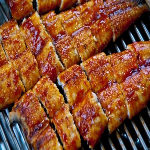

In [ ]:
inverted_label_encoder = {v: k for k, v in label_encoder.items()}

pic_num = 20
print(inverted_label_encoder[y_train[pic_num]])
cv2_imshow(X_train[pic_num] * 255)


# Modeling

입력으로 CNN은 배치 크기를 무시하고 형상(image_height, image_width, color_channels)의 텐서를 사용합니다. 이러한 차원을 처음 접하는 경우 color_channels는 (R,G,B)를 나타냅니다. 이 예에서는 CIFAR 이미지 형식인 형상(32, 32, 3)의 입력을 처리하도록 CNN을 구성합니다. input_shape 인수를 첫 번째 레이어에 전달하여 이를 수행할 수 있습니다.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))) # input_shape 들어가는 사진의 크기
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 56320 

모델을 완성하려면 마지막 합성곱 층의 출력 텐서(크기 (4, 4, 64))를 하나 이상의 Dense 층에 주입하여 분류를 수행합니다. Dense 층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서입니다. 먼저 3D 출력을 1D로 펼치겠습니다. 그다음 하나 이상의 Dense 층을 그 위에 추가하겠습니다. MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 소프트맥스 활성화 함수를 사용합니다

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5)) # class num

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 73984)             0

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
10/10 [==============================] - 3s 168ms/step - loss: 0.5495 - accuracy: 0.8934 - val_loss: 0.3829 - val_accuracy: 0.9375
Epoch 2/10
10/10 [==============================] - 0s 25ms/step - loss: 0.3130 - accuracy: 0.9373 - val_loss: 0.3319 - val_accuracy: 0.9125
Epoch 3/10
10/10 [==============================] - 0s 25ms/step - loss: 0.1013 - accuracy: 0.9875 - val_loss: 0.2237 - val_accuracy: 0.9250
Epoch 4/10
10/10 [==============================] - 0s 24ms/step - loss: 0.0200 - accuracy: 0.9969 - val_loss: 0.1237 - val_accuracy: 0.9500
Epoch 5/10
10/10 [==============================] - 0s 25ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1352 - val_accuracy: 0.9625
Epoch 6/10
10/10 [==============================] - 0s 25ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1659 - val_accuracy: 0.9625
Epoch 7/10
10/10 [==============================] - 0s 25ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1105 - val_accuracy: 0.9625
Epoch 8/10
1

4/4 - 0s - loss: 4.8551 - accuracy: 0.3400 - 256ms/epoch - 64ms/step


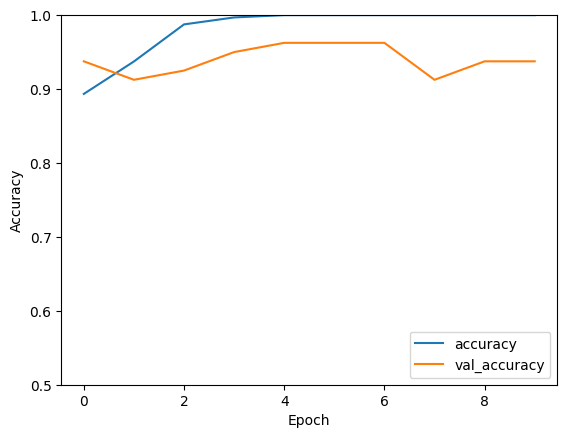

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
predictions = model.predict(X_test)

# Convert the logits to probabilities
probabilities = tf.nn.softmax(predictions)

# Get the class with the highest probability
predicted_classes = np.argmax(probabilities, axis=1)

# Compare the predicted classes with the actual classes
comparison = list(zip(predicted_classes, y_test))

# Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predicted_classes[i]}, Actual: {y_test[i]}')

4/4 [==============================] - 0s 8ms/step
Predicted: 4, Actual: 4
Predicted: 4, Actual: 0
Predicted: 1, Actual: 2
Predicted: 3, Actual: 1
Predicted: 2, Actual: 2
Predicted: 4, Actual: 4
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 3, Actual: 3
Predicted: 4, Actual: 0
